# Optimizers

In Sia, some algorithms (e.g. iLQR) and models (e.g. GPR) have hyperparameters that need to be optimized.  To avoid dependencies, Sia provides native implementations for several optimizers that are suited to this task, which solve the generic optimization problem

\begin{align}
&\theta^* = \arg \min_\theta~\mathcal{L}(\theta) \\
&\text{s.t.}~ \theta_{min} \leq \theta \leq \theta_{max}
\end{align}

Sia provides access to loss functions and their gradients if users wish to leverage an external optimization library.  Note that in some algorithms, the literature is written in the form of maximizing the objective function $f$, which is just the inverse of the loss, i.e. $\max -f(\theta) = \min\mathcal{L}(\theta)$.

**References**

1. [W. Hager and H. Zhang, A New Active Set Algorithm for Box Constrained Optimization, SIAM J. Optim, 2006.](https://www.math.lsu.edu/~hozhang/papers/box.pdf)

2. [B. Shahriari et. al., Taking the Human Out of the Loop: A Review of Bayesian Optimization, Proceedings of the IEEE, 104(1), 2016.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7352306)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(1)

**Example**

We'll illustrate the optimizers using an simple objective function that we wish to maximize

$$
f(x) = \sin(5x) - x^2
$$

The loss is just the negative of this function $\mathcal{L}(x) = -f(x)$.

In [2]:
# Define a simple objective test function that we would like to maximize
def objective(x: float) -> float:
    return np.sin(5 * x) - x**2

# Define the loss (reflection of the objective) that we would like to minimize
def loss(x: float) -> float:
    return -objective(x)

# Evaluate the true objective
xtest = np.linspace(-1, 1, 1001)
ytest = objective(xtest)

## Gradient Descent

In gradient descent, we minimize the loss

\begin{align}
&\theta^* = \arg \min_\theta~\mathcal{L}(\theta) \\
&\text{s.t.}~ \theta_{min} \leq \theta \leq \theta_{max}
\end{align}

subject to bounds $(\theta_{min}, \theta_{max})$.  The implementation in Sia is a monotonic gradient projection algorithm that finds the active box constraint.  Options for multistart from random or pre-specified initial conditions are available.  If the gradient of the loss function is not provided, a central difference numerical approximation scheme is used.

The example below shows gradient descent applied to the objective function using multi-starts.  If multi-starts are not used, the algorithm will occasionally converge to a local minima of the objective.

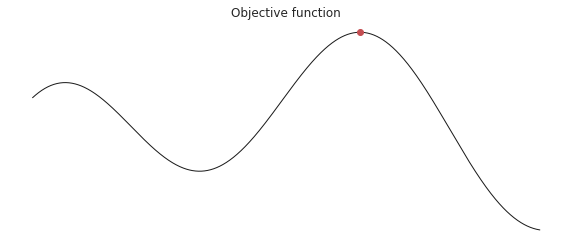

In [3]:
# Create the optimizer
gd = sia.GradientDescent(lower=np.array([-1]), upper=np.array([1]))
opts = gd.options()
opts.n_starts = 10
gd.setOptions(opts)
xopt = gd.minimize(loss)

# plot function and minima
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.despine(f, left=True, bottom=True)
ax.plot(xtest, ytest, '-k', lw=1)
ax.plot(xopt, objective(xopt), '.r', ms=12)
ax.axis("off")
ax.set_title("Objective function");

## Bayesian Optimization

Bayesian optimization is an active learning procedure for global joint optimization of expensive-to-evaluate objective functions.  It is useful for applications such as parameter tuning and continuous-action space Bandit learning problems.  Sia implements the typical formulation of a maximization

\begin{align}
&\theta^* = \arg \max_\theta~f(\theta) \\
&\text{s.t.}~ \theta_{min} \leq \theta \leq \theta_{max}
\end{align}

subject to bounds $(\theta_{min}, \theta_{max})$.  The gradient of the objective $f$ is assumed not available.  Bayesian Optimization works by iteratively approximating the objective function with a Gaussian Process, and selecting the next evaluation point $\theta$ by optimizing an acqusition function that balances previously seen data with unexplored regions of the parameter space.  Because the optimizer actively explores the parameter space, it is often used within a more involved evaluation.  Typical Bayesian Optimization usage follows

```{eval=False}
for k = 0,...:
  x <- bo.selectNextSample() // Optimizes the acqusition, trading off explore/exploit
  y <- queryObjective(x)     // User-implemented evaluation of x to produce an objective sample y
  bo.addDataPoint(x, y)      // Appends data
  
  // To avoid the GPR optimization falling into traps, we warm start the GP with a few samples until
  // we start actively searching.  Updating the models begins the active search routine
  if k > N:
      bo.updateModel()       // Retrains the surrogate objective function

xopt <- bo.getSolution()     // The current best solution can always be accessed
```

The update model step of the optimizer has the potential to fall into traps if few data points exist, which is a well-known issue with GPs.  We address the issue by providing an initial warm start of data points before optimizing the GP hyperparameters and beginning the active exploration.

The following illustrates usage of the Bayesian Optimizer in Sia.

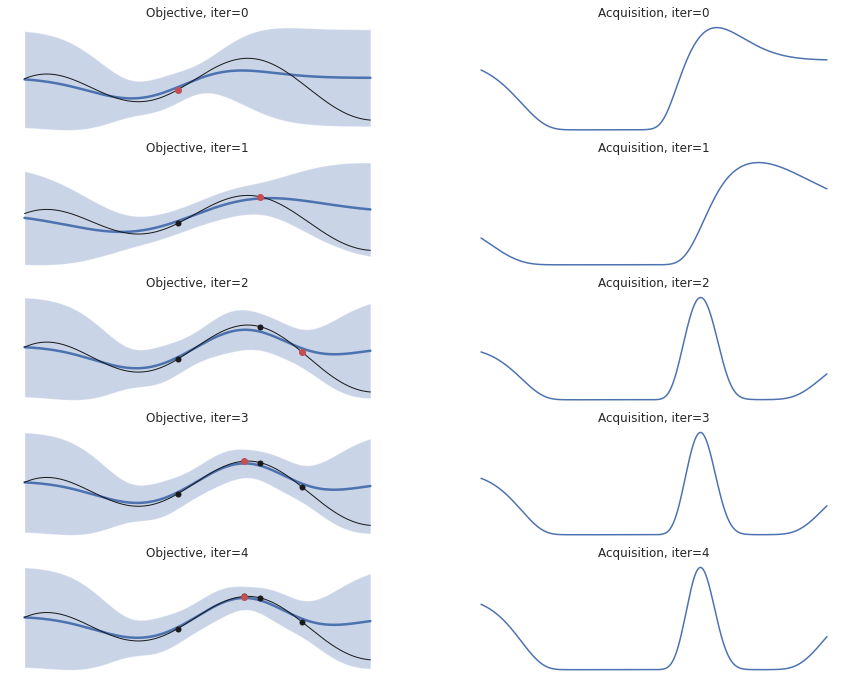

In [4]:
# Create the optimizer
acq = sia.BayesianOptimizer.EXPECTED_IMPROVEMENT
kernel = sia.SEKernel(0.2, 1)
bo = sia.BayesianOptimizer(lower=np.array([-1]),
                           upper=np.array([1]), 
                           kernel=kernel,
                           acquisition=acq,
                           beta=3)
    
# Plot the raw data
n_samples = 6
f, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(15, 18))
sns.despine(f, left=True, bottom=True)
X = np.zeros(n_samples)
Y = np.zeros(n_samples)
for i in range(n_samples):
    # Sample the next data point
    x = bo.selectNextSample()
    y = objective(x)
    bo.addDataPoint(x, y[0])
    X[i] = x
    Y[i] = y
    
    # Update the objective model.  Note that setting train = True
    # will optimize the GPR hyperparameters, use judiciously.
    train = False
    bo.updateModel(train=train)

    # Evaluate the surrogate model for visualization purposes
    obj_mu = np.zeros(len(xtest))
    obj_std = np.zeros(len(xtest))
    acq_func = [bo.acquisition([xt]) for xt in xtest]
    for k in range(len(xtest)):
        gaussian = bo.objective(np.array([xtest[k]]))
        obj_mu[k] = gaussian.mean()[0]
        obj_std[k] = np.sqrt(gaussian.covariance()[0, 0])
    
    # Plot the belief for each axis and overlay the training data
    ax[i, 0].fill_between(xtest, obj_mu + 3 * obj_std, obj_mu - 3 * obj_std,  alpha=0.3)
    ax[i, 0].plot(xtest, obj_mu, 'b', lw=2.5)
    ax[i, 0].plot(xtest, ytest, '-k', lw=1)
    ax[i, 0].plot(X[:i], Y[:i], '.k', ms=10)
    ax[i, 0].plot(x, y, '.r', ms=12)
    ax[i, 0].axis("off")
    ax[i, 0].set_title("Objective, iter={}".format(i))

    ax[i, 1].plot(xtest, acq_func)
    ax[i, 1].set_title("Acquisition, iter={}".format(i))
    ax[i, 1].axis("off")